In [1]:
# CARGAMOS LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import math

import pyarrow.parquet as pq
import pyarrow as pa
from io import BytesIO
import boto3

In [2]:
import tensorflow as tf
from keras.layers import Dense, Flatten, Activation, Dropout, Reshape, Conv1D, Masking, LSTM, Conv2D, Input, Multiply, Lambda
from keras.optimizers import Adam
from keras.regularizers import L2, L1L2, L1
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping

In [43]:
# CARGAMOS LOS RETORNOS DE TODOS LOS ACTIVOS QUE HAN PERTENECIDO AL IBEX35 Y EL BENCHMARK
returns = pd.read_csv('ibex_historical_returns.csv',index_col='date')
returns.index = pd.to_datetime(returns.index)
returns.head()

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL,benchmark
date,,,,,,,,,,,,,,,,,,,,,
1993-08-17,NaN,NaN,NaN,NaN,NaN,0.000831,NaN,NaN,NaN,0.023395,...,NaN,NaN,NaN,NaN,0.025183,NaN,NaN,NaN,NaN,0.016909
1993-08-18,NaN,NaN,NaN,NaN,NaN,-0.002079,NaN,NaN,NaN,0.003814,...,NaN,NaN,NaN,NaN,0.027093,NaN,NaN,NaN,NaN,0.012458
1993-08-19,NaN,NaN,NaN,NaN,NaN,-0.004088,NaN,NaN,NaN,-0.009661,...,NaN,NaN,NaN,NaN,-0.021590,NaN,NaN,NaN,NaN,0.007611
1993-08-20,NaN,NaN,NaN,NaN,NaN,-0.007048,NaN,NaN,NaN,-0.005882,...,NaN,NaN,NaN,NaN,-0.005504,NaN,NaN,NaN,NaN,-0.000402
1993-08-23,NaN,NaN,NaN,NaN,NaN,-0.002867,NaN,NaN,NaN,-0.027700,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,-0.003132


In [44]:
# CARGAMOS LOS DATOS DE PRECIOS DE CIERRE AJUSTADO PARA TODOS LOS ACTIVOS QUE HAN PERTENECIDO AL IBEX35 Y EL BENCHMARK
prices = pd.read_csv('ibex_historical_data.csv', index_col='date')
prices.index = pd.to_datetime(prices.index)
prices.head()

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL,benchmark
date,,,,,,,,,,,,,,,,,,,,,
1993-08-16,NaN,NaN,NaN,NaN,NaN,1.2025,NaN,NaN,NaN,3.4515,...,NaN,NaN,NaN,NaN,2.9683,NaN,NaN,NaN,NaN,3113.896729
1993-08-17,NaN,NaN,NaN,NaN,NaN,1.2035,NaN,NaN,NaN,3.5332,...,NaN,NaN,NaN,NaN,3.0440,NaN,NaN,NaN,NaN,3166.996826
1993-08-18,NaN,NaN,NaN,NaN,NaN,1.2010,NaN,NaN,NaN,3.5467,...,NaN,NaN,NaN,NaN,3.1276,NaN,NaN,NaN,NaN,3206.696777
1993-08-19,NaN,NaN,NaN,NaN,NaN,1.1961,NaN,NaN,NaN,3.5126,...,NaN,NaN,NaN,NaN,3.0608,NaN,NaN,NaN,NaN,3231.196777
1993-08-20,NaN,NaN,NaN,NaN,NaN,1.1877,NaN,NaN,NaN,3.4920,...,NaN,NaN,NaN,NaN,3.0440,NaN,NaN,NaN,NaN,3229.896729


In [45]:
# CARGAMOS LOS DATOS DE LA TASA DE RETORNO DE LOS BONOS A 3 MESES DE LOS EEUU
t_bill_files = [filename for filename in os.listdir('./Datos TFM') if filename.startswith("United States 3-Month Bond Yield")]
t_bill_data = pd.DataFrame()
for f in t_bill_files:
    file_path = './Datos TFM/'+f
    file = pd.read_csv(file_path)
    t_bill_data = pd.concat([t_bill_data,file],axis=0)
t_bill_data.index = pd.to_datetime(t_bill_data.Date)
t_bill_data.drop('Date',axis=1,inplace=True)
t_bill_data.head()

,Price,Open,High,Low,Change %
Date,,,,,
2023-07-25,5.436,5.432,5.439,5.426,0.34%
2023-07-24,5.418,5.453,5.486,5.418,-0.11%
2023-07-21,5.424,5.445,5.469,5.411,0.15%
2023-07-20,5.416,5.448,5.503,5.409,0.07%
2023-07-19,5.412,5.452,5.452,5.409,0.00%


In [46]:
def locate_in_df(df, value):
    a = df.to_numpy()
    row = np.where(a == value)[0][0]
    col = np.where(a == value)[1][0]
    return row, col
locate_in_df(returns,returns.min().min()), returns.min().min()

((5135, 36), -1.0195842263237869)

In [47]:
# ELIMINAMOS OUTLIERS EN LOS PRECIOS Y RETORNOS
prices.iloc[5136:,36] = np.nan
returns.iloc[5135:,36] = np.nan
prices.iloc[5626:, 2] = np.nan
returns.iloc[5625:, 2] = np.nan

In [48]:
# COMPLETAMOS LOS RETORNOS DE TODOS LOS ACTIVOS
# returns_cleaned = returns.apply(lambda x: x.fillna(abs(x.min())*-2), axis=1)
# returns_cleaned = returns
# returns_cleaned = returns.apply(lambda x: x.fillna(0), axis=1)
# DEFINIMOS NUESTRA TASA LIBRE DE RIESGO A TRAVÉS DE LOS VALORES DE LA TASA T-BILLS DE 3 MESES
risk_free_rate = t_bill_data['Price']/100
risk_free_rate = risk_free_rate.sort_index()
returns['risk_free_rate'] = risk_free_rate.loc[returns.index[0]:]
returns['risk_free_rate'] = returns['risk_free_rate'].fillna(method='ffill')
# AGREGAMOS LA OPCIÓN DE NO INVERTIR EN NINGUN ACTIVO COMO UNA COLUMNA CON RETORNO CERO
# returns['cash'] = 0

NECESITAMOS ARMAR UN DATASET CON INFORMACIÓN SOBRE CADA ACCIÓN CADA DIA. NUESTRO PROBLEMA NO SE BASA EN PREDECIR UN SERIE HISTÓRICA, SINO EN CLASIFICAR UN ACTIVO DEPENDIENDO DE SI EN EL ULTIMO PERÍODO ANALIZADO SE ENCUENTRA DENTRO DEL TOP 10 DE ACTIVOS BAJO UN CRITERIO O NO.

PARA ESTO ARMAREMOS UN DATASET PERO SIN IMPORTAR CUAL ES LA POSICIÓN DE CADA ACCIÓN EN SÍ DENTRO DEL RANKING. LO QUE NOS INTERESA SON LOS SIGUIENTES DATOS:
1) MEDIA DE RETORNOS DEL ULTIMO PERIODO A ANALIZAR                          OK
2) SHARPE DEL ULTIMO PERIODO A ANALIZAR                                     OK
3) CANTIDAD DE DIAS EN EL INDICE                                            OK
4) ALFA DE JENSEN DEL ULTIMO PERIODO A ANALIZAR                             OK
5) BETA DEL ULTIMO PERIODO A ANALIZAR                                       OK
6) DESVIACIÓN ESTANDARD DEL ULTIMO PERIODO A ANALIZAR                       OK
7) CANTIDAD DE DIAS EN EL TOP 10
8) MAXIMO DRAWDOWN DEL ULTIMO PERIODO A ANALIZAR                            COMO NO TENEMOS TODO EL HISTORICO DE DATOS DE TODOS LOS ACTIVOS NO ES CONVENIENTE CALCULAR ESTA
                                                                            MEDIDA
9) RATIO DE TREYNOR DEL ULTIMO PERIODO A ANALIZAR                           OK
10) MEDIDA DE MODIGLIANI DEL ULTIMO PERIODO A ANALIZAR                      OK
11) RATIO DE SORTINO DEL ULTIMO PERIODO A ANALIZAR                          OK
12) DISTANCIA CON RESPECTO AL BENCHMARK EN RATIO DE SHARPE                  OK
13) RATIO DE CALMAR DEL ULTIMO PERIODO A ANALIZAR                           COMO NO TENEMOS TODO EL HISTORICO DE DATOS DE TODOS LOS ACTIVOS NO ES CONVENIENTE CALCULAR ESTA
                                                                            MEDIDA
14) MINIMO RETORNO DEL ULTIMO PERIODO A ANALIZAR                            OK
15) MAXIMO RETORNO DEL ULTIMO PERIODO A ANALIZAR                            OK
16) RETORNO ACUMULADO DEL ULTIMO PERIODO A ANALIZAR                         

NUESTRA ETIQUETA A PREDECIR ES SI EL ACTIVO SE ENCUENTRA O NO EN EL TOP 10 DE ACTIVOS DEL INDICE. NUESTRO OBJETIVO NO ES PUNTUAR A LOS ACTIVOS DADO QUE LUEGO REALIZAREMOS LA ASIGNACIÓN DE PESOS A TRAVÉS DE MARKOWITZ. NUESTRO OBJETIVO ES SELECCIONAR ACTIVOS DEL TOTAL DE ACTIVOS QUE SE ENCUENTRAN EN EL INDICE:
- 0: NO SE ENCUENTRA EN EL TOP 10.
- 1: SE ENCUENTRA EN EL TOP 10.

DEBEMOS ITERAR PARA TODOS LOS ACTIVOS Y PARA TODOS LOS DIAS COMPLETANDO LA INFORMACIÓN DE NUESTRO DATASET. AL FINAL TENDREMOS UN DATASET CON N + 1 COLUMNAS (SIENDO N LA CANTIDAD DE FEATURES QUE TENEMOS EN NUESTRO DATASET) Y SUMANDO LA ETIQUETA 0 O 1 DEPENDIENDO DE SI ESTUVO EN EL INDICE EN ESE DIA O NO. NUESTRO DATASET FINAL TENDRÁ M FILAS SIENDO M LA CANTIDAD DE DIAS QUE HA COTIZADO CADA ACTIVO RESTANDO LA CANTIDAD DE PERIODOS QUE SE TOMEN PARA HACER EL PRIMER ANALISIS MULTIPLICADO POR LA CANTIDAD DE ACTIVOS. PARA LA ENTRADA A LA RED NO ES NECESARIO CONOCER QUÉ ACCIÓN ESTAMOS SELECCIONANDO DADO QUE LO QUE NOS IMPORTAN SON SUS CARACTERISTICAS EN EL DIA ANALIZADO. LO QUE SE BUSCA ES ENTONCES DADA UNA SERIE DE CARACTERISTICAS, ETIQUETAR UNA ACCIÓN. LUEGO SE TOMARÁN LOS RECAUDOS NECESARIOS PARA ENTENDER QUÉ ACCIÓN ES Y EN QUÉ MOMENTO. NUESTRO ANALISIS BUSCA TOMAR UNA DECISIÓN A DIA DE HOY BASANDONOS EN INFORMACIÓN HISTÓRICA. NO BUSCA PREDECIR LA BOLSA NI ANALIZAR QUE PASARÁ DE AQUI EN EL FUTURO.

In [50]:
# REALIZAMOS LA GENERACIÓN DE CARACTERISTICAS PARA UNA SOLA ACCIÓN PARA UN SOLO DÍA. ASÍ COMO TAMBIEN TRAERSE LOS DATOS DEL BENCHMARK Y LA TASA LIBRE DE RIESGO
# PRIMERO TOMAMOS LOS RETORNOS DIARIOS AL CIERRE DEL PRIMER PERIODO A SELECCIONAR. TOMAMOS COMO PERIODO 30 DÍAS.
DIAS = 30

In [294]:
dataset = pd.DataFrame()

for c in range(0, returns.shape[1] - 2):

    period_data = returns.iloc[:,[c,-2,-1]].dropna()
    returns_act = period_data.iloc[:,0]
    returns_risk_free_rate = period_data.iloc[:,-1]
    returns_benchmark = period_data.iloc[:,-2]

    for i in range(period_data.shape[0] - DIAS):
        # OBTENEMOS EL NOMBRE DEL ACTIVO
        stock_name = returns_act.name
        
        # OBTENEMOS LOS RETORNOS DEL PRIMER PERIODO, CALCULAMOS LA MEDIA Y LA DESVIACIÓN ESTANDARD DE ESE PERIODO
        previous_period_act = returns_act[i:DIAS+i]
        previous_period_mean_returns = previous_period_act.mean()
        previous_period_std_returns = previous_period_act.std()

        previous_period_max_returns = previous_period_act.max()
        previous_period_min_returns = previous_period_act.min()

        # OBTENEMOS LOS DIAS QUE ESTUVO EN EL INDICE HASTA EL MOMENTO
        days_in_index = DIAS + i

        # OBTENEMOS EL DIA DE ANALISIS
        date = previous_period_act.index[-1]

        # PARA CALCULAR EL RATIO DE SHARPE DEBEMOS OBTENER LOS DATOS DE LA TASA LIBRE DE RIESGO PARA ESE DIA Y DIVIDIR EL RETORNO MEDIO AJUSTADO POR LA TASA LIBRE DE RIESGO
        # POR LA DESVIACIÓN ESTANDAR DE LOS RETORNOS.
        period_risk_free_rate = returns_risk_free_rate.iloc[DIAS+i]

        # CALCULAMOS EL RATIO DE SHARPE PARA ESTE PERIODO
        period_sharpe_ratio = (previous_period_mean_returns - period_risk_free_rate) / previous_period_std_returns

        # CALCULAMOS LA 
        downside_dev  = np.minimum(1e-9, previous_period_act - period_risk_free_rate)**2
        downside_dev = np.sqrt(downside_dev.mean())

        # CALCULAMOS EL RATIO DE SORTINO
        period_sortino_ratio =  (previous_period_mean_returns - period_risk_free_rate) / downside_dev

        # CALCULAMOS LA MEDIA Y DESVIACION ESTANDAR DE LOS RETORNOS DEL BENCHMARK
        previous_period_benchmark = returns_benchmark[i:DIAS+i]
        previous_period_mean_returns_benchmark = previous_period_benchmark.mean()
        previous_period_std_returns_benchmark = previous_period_benchmark.std()

        # CALCULAMOS LA BETA DEL ACTIVO CON RESPECTO AL BENCHMARK
        market_stock_cov = np.cov(previous_period_act, previous_period_benchmark)
        beta = (market_stock_cov[0, 1]/market_stock_cov[1, 1])

        # CALCULAMOS EL RATO DE TREYNOR
        treynor_ratio = previous_period_mean_returns / beta

        # AJUSTAMOS LOS RETORNOS DEL ACTIVO POR LOS RETORNOS DEL BENCHMARK
        benchmark_adjusted_returns = (previous_period_act - previous_period_benchmark)
        benchmark_adjusted_returns_mean = benchmark_adjusted_returns.mean()
        benchmark_adjusted_returns_std = benchmark_adjusted_returns.std()

        # CALCULAMOS LA DISTANCIA MEDIA AL BENCHMARK
        benchmark_distance = np.sqrt(np.mean((previous_period_benchmark - previous_period_act)**2))

        # CALCULAMOS EL INFORMATION RATIO
        information_ratio = benchmark_adjusted_returns_mean / benchmark_adjusted_returns_std

        # CALCULAMOS LA MEDIDA DE MODIGLIANI
        modigliani_measure = ((period_sharpe_ratio * previous_period_std_returns_benchmark) + period_risk_free_rate)

        # CALCULAMOS EL ALFA DE JENSEN
        alfa_jensen = previous_period_mean_returns - (period_risk_free_rate - beta * (previous_period_mean_returns_benchmark - period_risk_free_rate))

        data_period_stock = {
            'ticker': stock_name,
            'date': date,
            'days_in_index': days_in_index,
            'period_mean_return': previous_period_mean_returns,
            'period_std_return': previous_period_std_returns,
            'period_min_return': previous_period_min_returns,
            'period_max_return': previous_period_max_returns,
            'sharpe_ratio': period_sharpe_ratio,
            'sortino_ratio': period_sortino_ratio,
            'beta': beta,
            'treynor_ratio': treynor_ratio,
            'benchmark_distance': benchmark_distance,
            'informatio_ratio': information_ratio,
            'modigliani_measure': modigliani_measure,
            'alfa_jensen': alfa_jensen
        }

        data_period_stock = pd.DataFrame([data_period_stock])
        dataset = pd.concat([dataset,data_period_stock], axis=0)
    print(stock_name)

A3TV
ABE
ABG.P_1
ABG
ACS
ACX_1
ACX_2
AENA
AGS
ALB_2
ALB_3
ALM
ALT
AMP
AMS_1
ANA_1
ANA_2
ANE
BBVA
BKIA
BKIA_1
BKT
BME
BTO_1
BTO_2
CABK
CIE
CIN
CLNX
COL
COL_1
CRI_2
DIA
DRC
EBRO
EBRO_1
ELE
ELE_1
ENC
ENC_1
ENG
FCC
FDR
FER
GAM
GAM_1
GRF
IAG
IBE
IBLA
IBR
IDR
ITX
JAZ
LOR
MAP
MAP_1
MAP_2
MAS
MEL
MRL
MTS
NHH
NHH_2
NTGY
OHLA
PHM
POP
PRS
PRS_1
PUL
RED
REE
REE_1
REP
ROVI
SAB
SAN
SAN_1
SCYR
SCYR_1
SCYR_2
SGC
SGRE
SLR
SOL
TEF
TEM
TL5
TRE
TUB
UNF
VIS
VIS_1
VIS_2
VIS_3
ZEL


C:\Users\aleja\AppData\Local\Temp\ipykernel_18144\2579837763.py:63: RuntimeWarning: invalid value encountered in scalar divide
  information_ratio = benchmark_adjusted_returns_mean / benchmark_adjusted_returns_std


benchmark
risk_free_rate


In [315]:
# dataset = dataset[~dataset['ticker'].isin(['risk_free_rate','benchmark'])]
dataset.reset_index(drop=True, inplace=True)

In [321]:
dataset_2 = dataset.copy()

In [344]:
# ITERAMOS PARA TODAS LAS FECHAS CON EL OBJETIVO DE ETIQUETAR LOS DATOS
# NUESTRO CRITERIO SE BASARÁ EN EL RATIO DE SHARPE. AQUELLOS ACTIVOS QUE ESTÉN EN EL TOP 10 DE RATIO DE SHARPE PARA CADA FECHA SE LOS ETIQUETARÁ CON UN 1, MIENTRAS
# QUE AQUELLOS QUE SE ENCUENTREN FUERA DEL TOP 10 PARA CADA FECHA SE LOS ETIQUETARÁ CON UN 0
len_dates = dataset['date'].unique().shape[0]
for i in range(len_dates):
    top_indexes = dataset_2[dataset_2['date'] == dataset_2['date'].unique()[i]].sort_values('sharpe_ratio',ascending=False)[:10].index
    not_top_indexes = dataset_2[dataset_2['date'] == dataset_2['date'].unique()[i]].sort_values('sharpe_ratio',ascending=False)[10:].index
    dataset_2.loc[top_indexes,'label'] = 1
    dataset_2.loc[not_top_indexes,'label'] = 0

In [360]:
dataset_2[dataset_2['label']==1]

,ticker,date,period_mean_return,period_std_return,period_min_return,period_max_return,sharpe_ratio,sortino_ratio,beta,treynor_ratio,benchmark_distance,informatio_ratio,modigliani_measure,alfa_jensen,label
0,A3TV,2005-08-19,-0.002801,0.011520,-0.030143,0.016199,-3.273502,-0.957734,0.531862,-0.005267,0.011935,-0.343632,0.019577,-0.055674,1
1,A3TV,2005-08-22,-0.002361,0.011360,-0.030143,0.016199,-3.294102,-0.958229,0.718641,-0.003285,0.011286,-0.305949,0.020188,-0.061903,1
2,A3TV,2005-08-23,-0.002069,0.011383,-0.030143,0.016199,-3.250204,-0.957165,0.582280,-0.003553,0.011391,-0.252988,0.019526,-0.056889,1
3,A3TV,2005-08-24,-0.002149,0.011419,-0.030143,0.016199,-3.241922,-0.956960,0.669675,-0.003209,0.011217,-0.236099,0.019801,-0.060056,1
5,A3TV,2005-08-26,-0.002955,0.012315,-0.030143,0.019761,-3.108018,-0.953432,0.544035,-0.005431,0.012341,-0.231089,0.019267,-0.057561,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209311,ZEL,2004-10-14,0.001302,0.010004,-0.016379,0.022019,-1.589050,-0.852085,0.599597,0.002172,0.009435,-0.000105,0.007131,-0.025429,1
209312,ZEL,2004-10-15,0.002036,0.010275,-0.016379,0.022019,-1.491359,-0.836505,0.631354,0.003224,0.009635,0.092041,0.007989,-0.025566,1
209313,ZEL,2004-10-18,0.001713,0.010060,-0.016379,0.022019,-1.616994,-0.855580,0.582927,0.002938,0.009627,0.089447,0.008155,-0.026258,1
209314,ZEL,2004-10-19,0.001230,0.010394,-0.016379,0.022019,-1.611542,-0.854732,0.442916,0.002777,0.010429,0.024268,0.007944,-0.024283,1


In [358]:
bucket_name = 'stock-market-historical-data'
table = pa.Table.from_pandas(dataset_2)
buf = BytesIO()
pq.write_table(table, buf)

s3.Object(bucket_name, 'categorical_dataset').put(Body=buf.getvalue())

{'ResponseMetadata': {'RequestId': '3QSY6SFKW1X9H9ME',
  'HostId': 'Kkr4ZRj327AEQwuf1OK44WuRJw+8uE+MUAv6Ee9OorsAw8ePBE7S0/UK4EeVdJ4fp1lvhrDL2UTIRFd9yQ0ixA==',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'Kkr4ZRj327AEQwuf1OK44WuRJw+8uE+MUAv6Ee9OorsAw8ePBE7S0/UK4EeVdJ4fp1lvhrDL2UTIRFd9yQ0ixA==',
   'x-amz-request-id': '3QSY6SFKW1X9H9ME',
   'date': 'Sat, 19 Aug 2023 11:32:04 GMT',
   'x-amz-version-id': 'h2uoVSQFzaHTuzXQCgJrqQp9OmK6VBlG',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"1985c76dd10554ab78eef4f9446e2c31"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"1985c76dd10554ab78eef4f9446e2c31"',
 'ServerSideEncryption': 'AES256',
 'VersionId': 'h2uoVSQFzaHTuzXQCgJrqQp9OmK6VBlG'}

In [4]:
# INICIALIZAMOS UNA SESION EN AWS
session = boto3.Session(
    aws_access_key_id=os.environ['S3_ACCESS_KEY'],
    aws_secret_access_key=os.environ['S3_SECRET_KEY'],
    region_name=os.environ['S3_REGION'])

s3_client = boto3.client('s3')
s3 = boto3.resource('s3')

In [5]:
bucket_name = 'stock-market-historical-data'
processed_folder = 'processed/marketstack/'
file_name = 'ibex_historical_data'
full_path = processed_folder + file_name

In [6]:
def download_s3_parquet_file(s3, bucket, key):
    buffer = BytesIO()
    s3.Object(bucket, key).download_fileobj(buffer)
    return buffer

In [7]:
# CARGAMOS EL DATAFRAME CON TODOS LOS DATOS DE CIERRE DE TODOS LOS ACTIVOS DESDE 02/01/1991
file_name = 'categorical_dataset'
dataset = pd.DataFrame(pq.read_table(download_s3_parquet_file(s3, bucket_name,file_name)).to_pandas())
dataset.head()

,ticker,date,period_mean_return,period_std_return,period_min_return,period_max_return,sharpe_ratio,sortino_ratio,beta,treynor_ratio,benchmark_distance,informatio_ratio,modigliani_measure,alfa_jensen,label
0,A3TV,2005-08-19,-0.002801,0.011520,-0.030143,0.016199,-3.273502,-0.957734,0.531862,-0.005267,0.011935,-0.343632,0.019577,-0.055674,1
1,A3TV,2005-08-22,-0.002361,0.011360,-0.030143,0.016199,-3.294102,-0.958229,0.718641,-0.003285,0.011286,-0.305949,0.020188,-0.061903,1
2,A3TV,2005-08-23,-0.002069,0.011383,-0.030143,0.016199,-3.250204,-0.957165,0.582280,-0.003553,0.011391,-0.252988,0.019526,-0.056889,1
3,A3TV,2005-08-24,-0.002149,0.011419,-0.030143,0.016199,-3.241922,-0.956960,0.669675,-0.003209,0.011217,-0.236099,0.019801,-0.060056,1
4,A3TV,2005-08-25,-0.003519,0.011605,-0.030143,0.014156,-3.325083,-0.958956,0.821449,-0.004284,0.011298,-0.328375,0.018543,-0.067348,0


In [8]:
dataset_2 = dataset.copy()

In [33]:
x_axis_labels = np.sort(dataset_2['label'].unique().astype(str))
label_count = dataset_2['label'].value_counts()
legend_label = ['Stocks out of Top 10','Stocks in Top 10']

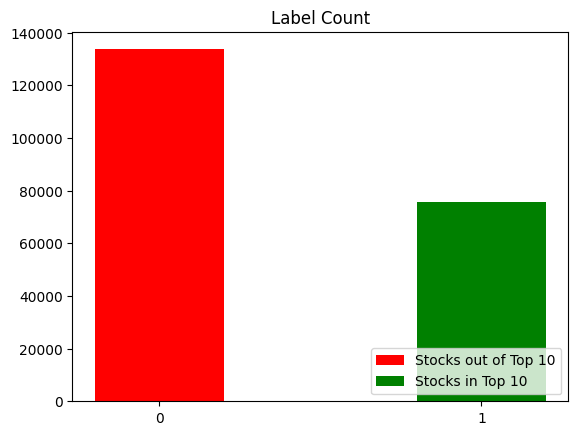

In [41]:
plt.bar(x_axis_labels, label_count, width=0.4, label=legend_label, color=['red','green'])
plt.title('Label Count')
plt.legend(loc='lower right');

In [53]:
dataset_2

,ticker,date,period_mean_return,period_std_return,period_min_return,period_max_return,sharpe_ratio,sortino_ratio,beta,treynor_ratio,benchmark_distance,informatio_ratio,modigliani_measure,alfa_jensen,label
0,A3TV,2005-08-19,-0.002801,0.011520,-0.030143,0.016199,-3.273502,-0.957734,0.531862,-0.005267,0.011935,-0.343632,0.019577,-0.055674,1
1,A3TV,2005-08-22,-0.002361,0.011360,-0.030143,0.016199,-3.294102,-0.958229,0.718641,-0.003285,0.011286,-0.305949,0.020188,-0.061903,1
2,A3TV,2005-08-23,-0.002069,0.011383,-0.030143,0.016199,-3.250204,-0.957165,0.582280,-0.003553,0.011391,-0.252988,0.019526,-0.056889,1
3,A3TV,2005-08-24,-0.002149,0.011419,-0.030143,0.016199,-3.241922,-0.956960,0.669675,-0.003209,0.011217,-0.236099,0.019801,-0.060056,1
4,A3TV,2005-08-25,-0.003519,0.011605,-0.030143,0.014156,-3.325083,-0.958956,0.821449,-0.004284,0.011298,-0.328375,0.018543,-0.067348,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209358,ZEL,2004-12-23,-0.002402,0.008431,-0.016590,0.021979,-2.871874,-0.946093,0.445910,-0.005386,0.009521,-0.499642,0.005598,-0.033085,0
209359,ZEL,2004-12-27,-0.002484,0.008491,-0.016590,0.021979,-2.940236,-0.948382,0.448289,-0.005541,0.009632,-0.514711,0.006015,-0.034153,0
209360,ZEL,2004-12-28,-0.002563,0.008529,-0.016590,0.021979,-2.893856,-0.946844,0.448801,-0.005711,0.009690,-0.519082,0.005930,-0.033730,0
209361,ZEL,2004-12-29,-0.002522,0.008500,-0.016590,0.021979,-2.881434,-0.946421,0.427910,-0.005893,0.009764,-0.525455,0.005927,-0.033003,0


In [54]:
for c in range(0, returns.shape[1] - 2):

    period_data = returns.iloc[:,[c,-2,-1]].dropna()
    returns_act = period_data.iloc[:,0]
    returns_risk_free_rate = period_data.iloc[:,-1]
    returns_benchmark = period_data.iloc[:,-2]

    for i in range(period_data.shape[0] - DIAS):
        previous_period_act = returns_act[i:DIAS+i]
        days_in_index = DIAS + i
        date = previous_period_act.index[-1]
        dataset_2.loc[(dataset_2['date']==date) & (dataset_2['ticker']==c)]['days_in_index'] = days_in_index
    print(dataset_2.loc[(dataset_2['date']==date) & (dataset_2['ticker']==c)]['days_in_index'])

KeyError: 'days_in_index'

In [55]:
from sklearn.utils import shuffle
dataset_2 = dataset_2.iloc[:,2:]
dataset_2 = shuffle(dataset_2)

In [56]:
val_split = math.floor(dataset_2.shape[0]*0.7)
test_split = math.floor(dataset_2.shape[0]*0.9)

In [57]:
X_train = dataset_2.iloc[:test_split,:-1]
X_val = dataset_2.iloc[val_split:test_split,:-1]
X_test = dataset_2.iloc[test_split:,:-1]
y_train = dataset_2.iloc[:test_split,-1]
y_val = dataset_2.iloc[val_split:test_split,-1]
y_test = dataset_2.iloc[test_split:,-1]

In [58]:
from sklearn.preprocessing import StandardScaler

In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [60]:
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [61]:
X_train_scaled.shape, X_test_scaled.shape, X_val_scaled.shape

((188426, 12), (20937, 12), (41872, 12))

In [62]:
input = Input(shape=(X_train_scaled.shape[1],))
    
layer_1 = Dense(10, activation='relu', kernel_regularizer=L2(0.001))(input)
dropout_1 = Dropout(0.5)(layer_1)
layer_2 = Dense(5, activation='relu', kernel_regularizer=L2(0.001))(dropout_1)
dropout_2 = Dropout(0.5)(layer_2)

flatten = Flatten()(dropout_2)

output = Dense(1, activation='sigmoid')(flatten)

model = Model(inputs=input, outputs=output)

model.summary()

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense (Dense)               (None, 10)                130       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6     

In [63]:
earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    # mode='min',
    restore_best_weights=True
    )

In [64]:
batch_size = 32
h = model.fit(
    X_train_scaled, y_train,
      epochs=100,
      batch_size = batch_size,
      validation_data = (X_val_scaled, y_val),
      callbacks = [earlystopping],
      shuffle=True,
      verbose=True
          )


Epoch 1/100
5889/5889 [==============================] - 13s 2ms/step - loss: 0.6502 - accuracy: 0.6418 - val_loss: 0.5371 - val_accuracy: 0.7254
Epoch 2/100
5889/5889 [==============================] - 12s 2ms/step - loss: 0.5655 - accuracy: 0.6973 - val_loss: 0.4609 - val_accuracy: 0.7822
Epoch 3/100
5889/5889 [==============================] - 12s 2ms/step - loss: 0.5258 - accuracy: 0.7199 - val_loss: 0.4266 - val_accuracy: 0.8120
Epoch 4/100
5889/5889 [==============================] - 13s 2ms/step - loss: 0.5052 - accuracy: 0.7460 - val_loss: 0.4000 - val_accuracy: 0.8435
Epoch 5/100
5889/5889 [==============================] - 12s 2ms/step - loss: 0.4908 - accuracy: 0.7628 - val_loss: 0.3859 - val_accuracy: 0.8501
Epoch 6/100
5889/5889 [==============================] - 13s 2ms/step - loss: 0.4792 - accuracy: 0.7691 - val_loss: 0.3774 - val_accuracy: 0.8543
Epoch 7/100
5889/5889 [==============================] - 13s 2ms/step - loss: 0.4760 - accuracy: 0.7724 - val_loss: 0.3724 -

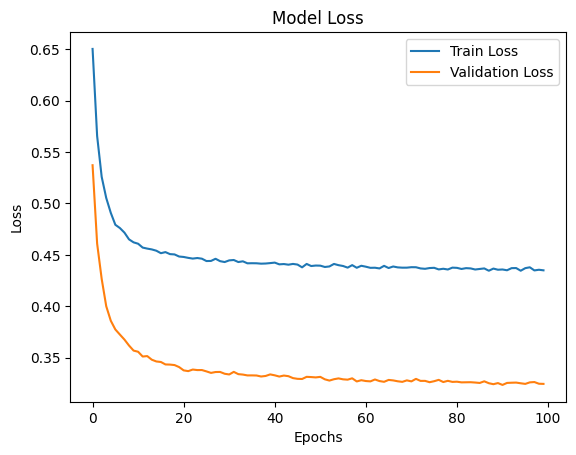

In [65]:
plt.plot(h.history['loss'],label='Train Loss')
plt.plot(h.history['val_loss'],label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

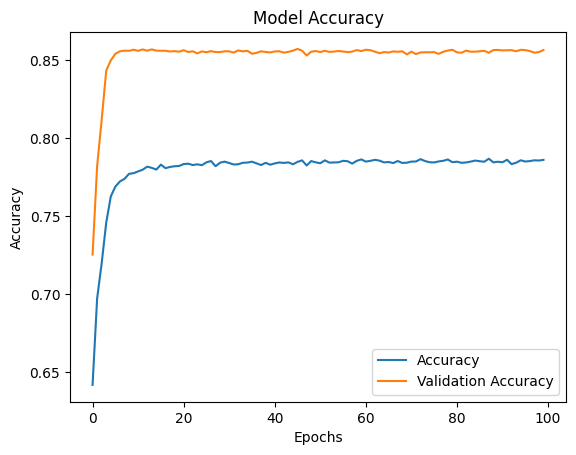

In [66]:
plt.plot(h.history['accuracy'],label='Accuracy')
plt.plot(h.history['val_accuracy'],label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

In [74]:
from sklearn.inspection import permutation_importance
perm = permutation_importance(model, X_test_scaled, y_test, scoring='neg_mean_squared_error', n_repeats=10, random_state=42, n_jobs=2)

655/655 [==============================] - 1s 1ms/step


In [ ]:
perm

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

In [ ]:
tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

In [147]:
index = val_split
indexes = list(returns_cleaned[::5].iloc[index:,:-2].dropna(axis=1, how='all'))

In [449]:
model.evaluate(X_test_scaled, y_test)

655/655 [==============================] - 1s 2ms/step - loss: 0.4316 - accuracy: 0.8557


[0.4316217005252838, 0.8556622266769409]

In [487]:
y_pred = model.predict(X_test_scaled)

655/655 [==============================] - 1s 1ms/step


In [488]:
# auc = metrics.roc_auc_score(y_test, y_pred_proba)

In [489]:
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.

In [492]:
y_pred = pd.DataFrame(y_pred)
y_test = y_test.reset_index()

ValueError: cannot insert level_0, already exists

In [491]:
predictions = pd.concat([y_test, y_pred],axis=1)

In [493]:
predictions.drop('level_0',axis=1,inplace=True)

In [504]:
predictions = predictions.rename(columns={0:'y_pred','label':'y_test'})

In [505]:
predictions['y_pred'] = predictions['y_pred'].astype('int')

In [519]:
dataset_results = dataset_2.iloc[predictions['index']].sort_index() 

In [525]:
dataset_results[(dataset_results['sharpe_ratio'] > 0) & (dataset_results['label'] == 1)]

,period_mean_return,period_std_return,period_min_return,period_max_return,sharpe_ratio,sortino_ratio,beta,treynor_ratio,benchmark_distance,informatio_ratio,modigliani_measure,alfa_jensen,label
3044,0.002413,0.010926,-0.015214,0.034122,0.155851,0.288237,0.619207,0.003897,0.009085,0.130253,0.002611,0.002018,1
3059,0.000882,0.013259,-0.032110,0.021267,0.016741,0.022793,0.756478,0.001166,0.008448,0.116472,0.000897,-0.000362,1
3231,0.006549,0.036625,-0.043548,0.170041,0.137317,0.364007,1.061141,0.006172,0.028735,0.095564,0.004404,0.007416,1
3361,0.004531,0.015424,-0.031355,0.028957,0.188726,0.290490,0.535789,0.008456,0.014827,0.181398,0.004610,0.003029,1
3419,0.002615,0.013604,-0.019069,0.032102,0.162100,0.297388,0.826877,0.003163,0.010790,0.218198,0.002091,0.002096,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208547,0.003057,0.014597,-0.015652,0.069854,0.140252,0.363910,-0.171347,-0.017842,0.021224,0.234098,0.002837,0.002539,1
208558,0.001429,0.015546,-0.015652,0.069854,0.023762,0.050905,-0.138211,-0.010342,0.021073,0.153558,0.001362,0.000768,1
208774,0.000848,0.007873,-0.015666,0.022280,0.040418,0.064310,0.434922,0.001950,0.008494,0.252522,0.000847,-0.000462,1
208777,0.000684,0.008017,-0.015666,0.022280,0.021750,0.033877,0.387963,0.001764,0.009183,0.209898,0.000711,-0.000502,1


In [518]:
dataset_2.iloc[dataset.iloc[predictions['index']].index].sort_index()

,period_mean_return,period_std_return,period_min_return,period_max_return,sharpe_ratio,sortino_ratio,beta,treynor_ratio,benchmark_distance,informatio_ratio,modigliani_measure,alfa_jensen,label
0,-0.002801,0.011520,-0.030143,0.016199,-3.273502,-0.957734,0.531862,-0.005267,0.011935,-0.343632,0.019577,-0.055674,1
11,-0.002158,0.012284,-0.030143,0.019761,-2.983403,-0.949755,0.519099,-0.004156,0.012375,-0.239322,0.016800,-0.054152,1
14,-0.001138,0.011737,-0.024898,0.019761,-3.036300,-0.951366,0.529402,-0.002150,0.011644,-0.184761,0.015583,-0.053366,0
28,-0.000554,0.010188,-0.024898,0.019761,-3.431860,-0.961327,0.219373,-0.002525,0.011437,-0.249415,0.012279,-0.042017,0
34,-0.000211,0.009005,-0.016211,0.019761,-3.951244,-0.970409,0.072649,-0.002901,0.010786,-0.252233,0.011259,-0.037971,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209322,-0.000310,0.009986,-0.016652,0.021506,-1.963648,-0.894329,0.521772,-0.000593,0.009841,-0.170522,0.004510,-0.028964,0
209344,-0.000918,0.009684,-0.016652,0.027102,-2.373772,-0.924518,0.369926,-0.002482,0.010499,-0.249059,0.005051,-0.030539,0
209347,-0.001056,0.009717,-0.016652,0.027102,-2.401531,-0.926010,0.350974,-0.003010,0.010634,-0.266944,0.005516,-0.030549,0
209360,-0.002563,0.008529,-0.016590,0.021979,-2.893856,-0.946844,0.448801,-0.005711,0.009690,-0.519082,0.005930,-0.033730,0
